# Classifier architecture design
Have a couple of ideas to play with here. Let's give the following a college try:

- **Tiling**: Break the data into overlapping chunks by fragment length. Then train a classifier on each chunk. A given fragment will then fall in the length range of n classifiers. Combine the outputs somehow in a clever way, could even train a second tier of classifiers that take the output from the first stages to make the final prediction.
- **Clustering**: Can we somehow cluster text by similarity and then train a classifier for each cluster?
- **Bagging**: Train n classifiers on n random subsets of the data. Then a 'master' classifier to combine the outputs.

Note about the classifier: will be using XGBoost - it's the fastest of the bunch from the preliminary classifier selection results and, after optimization has the best balance of false positive and false negative rates. I also can be used via the scikit-learn API, so any other classifier from scikit is a drop in replacement. This can obviously be re-evaluated later, but for now, it's a good starting point.

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

/mnt/arkk/llm_detector/classifier


## 1. Load and prepare data
Let's take a look:

In [2]:
# The dataset - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
working_hdf5_file = f'{config.DATA_PATH}/{dataset_name}_stage_I_experimental.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(working_hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Take small sample for rapid development and testing
data_df = data_df.sample(n = 5000)

# Close hdf5 connection
data_lake.close()

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 45534 to 24406
Data columns (total 26 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Fragment ID                                                                       5000 non-null   int64  
 1   Source record num                                                                 5000 non-null   int64  
 2   Fragment length (words)                                                           5000 non-null   int64  
 3   Fragment length (tokens)                                                          5000 non-null   int64  
 4   Dataset                                                                           5000 non-null   object 
 5   Source                                                                            5000 non-null   object 
 6   

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,...,Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score,Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score,Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score
45534,45534,8019,10,14,cnn,human,human,"go on the counter-attack, which Van Gaal will ...",3.752,5.003906,...,0.572993,1.194079,0.540701,-2.292214,-2.330831,-0.178527,0.138053,0.014080,0.162527,0.013933
10156,10156,4999,173,233,cc_news,synthetic,llama2-13b,love to learn new things and we’re often capti...,2.227,2.781250,...,0.470288,2.825525,0.432649,-3.250992,-3.302194,-0.335530,0.162160,0.011109,0.184196,0.011540
10106,10106,10360,112,147,pubmed,human,human,appear to be similar or higher rate than those...,2.992,3.080078,...,2.355340,0.078179,2.909813,-3.114273,-3.038184,0.468137,0.048111,0.057851,0.062366,0.059954
13241,13241,10785,164,221,pubmed,human,human,correction transposition of the great arteries...,2.809,3.074219,...,0.464381,1.290667,0.395569,-3.172137,-2.926000,1.500976,0.009763,0.187162,0.012642,0.198667
3091,3091,2997,18,19,cc_news,human,human,to purchase private health policies. The idea ...,3.805,3.716797,...,3.134692,0.246543,3.411829,-3.386279,-3.492842,-0.733066,0.211541,0.012241,0.214355,0.013847


OK, let's get the data into shape to train a classifier.

In [4]:
# Split the data into training and testing
training_data_df = data_df.sample(frac = 0.7, random_state = 42)
testing_data_df = data_df.drop(training_data_df.index)

# Set length threshold
training_data_df = training_data_df[training_data_df['Fragment length (words)'] > 50].copy()
testing_data_df = testing_data_df[testing_data_df['Fragment length (words)'] > 50].copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop un-trainable features
feature_drops = [
    'Fragment ID',
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)',
    'Fragment length (words)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

print(f'Training data: {len(features_train_df)} examples')
print(f'Test data: {len(features_test_df)} examples')

Training data: 2790 examples
Test data: 1200 examples


Make a data structure to collect results for plotting as we go.

In [9]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Set some parameters
cv_folds = 3
random_state = 23

## 2. Fragment length tiling

Plan here is to break the data into chunks based on fragment length and then train a classifier for each bin. Let's see if it works.

In [10]:
# Bin the data
bins = pd.cut(training_data_df.loc[:, 'Fragment length (tokens)'], 5)

training_data_df.loc[:, 'Length bin (tokens)'] = bins
training_data_df = training_data_df.astype({'Length bin (tokens)': str})

training_data_df.info()
training_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2790 entries, 34239 to 18107
Data columns (total 17 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Fragment length (tokens)                                                          2790 non-null   int64  
 1   Source                                                                            2790 non-null   object 
 2   Perplexity                                                                        2790 non-null   float64
 3   Cross-perplexity                                                                  2790 non-null   float64
 4   Perplexity ratio score                                                            2790 non-null   float64
 5   Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score  2790 non-null   float64
 6   

,Fragment length (tokens),Source,Perplexity,Cross-perplexity,Perplexity ratio score,Synthetic-human perplexity ratio exponential gaussian fit Kullback-Leibler score,Human-synthetic perplexity ratio exponential gaussian fit Kullback-Leibler score,Synthetic-human perplexity ratio kernel density estimate Kullback-Leibler score,Human-synthetic perplexity ratio kernel density estimate Kullback-Leibler score,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score,Length bin (tokens)
34239,336,human,2.889,2.740234,1.054170,0.349204,2.695885,0.374127,2.435506,-3.078032,-2.776885,1.763186,0.013496,0.204774,0.015925,0.212238,"(251.4, 362.6]"
10401,137,human,3.531,3.626953,0.973613,0.054884,2.425009,0.075732,3.004458,-3.011524,-2.847788,0.959376,0.014478,0.121180,0.019863,0.130915,"(28.444, 140.2]"
2598,198,human,2.941,2.933594,1.002663,0.121073,3.078256,0.149282,3.679812,-3.371718,-3.158287,1.393708,0.008966,0.176579,0.012051,0.188843,"(140.2, 251.4]"
28091,291,synthetic,2.611,2.990234,0.873285,2.585622,0.089620,3.258444,0.098029,-3.052720,-3.080471,-0.170205,0.136751,0.014309,0.161275,0.014136,"(251.4, 362.6]"
35787,94,synthetic,2.387,2.605469,0.916042,0.888554,0.518707,1.188141,0.452892,-3.270959,-3.146063,0.801458,0.021560,0.099364,0.028965,0.106624,"(28.444, 140.2]"


In [11]:
# Grab the bin strings
bin_strings = list(training_data_df['Length bin (tokens)'].unique())
bin_strings.sort()
print(bin_strings)

['(140.2, 251.4]', '(251.4, 362.6]', '(28.444, 140.2]', '(362.6, 473.8]', '(473.8, 585.0]']


Bin: (140.2, 251.4]
Training data: 982 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>



Bin: (251.4, 362.6]
Training data: 760 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (28.444, 140.2]
Training data: 768 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (362.6, 473.8]
Training data: 271 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>

Bin: (473.8, 585.0]
Training data: 9 examples
Model is: <class 'xgboost.sklearn.XGBClassifier'>



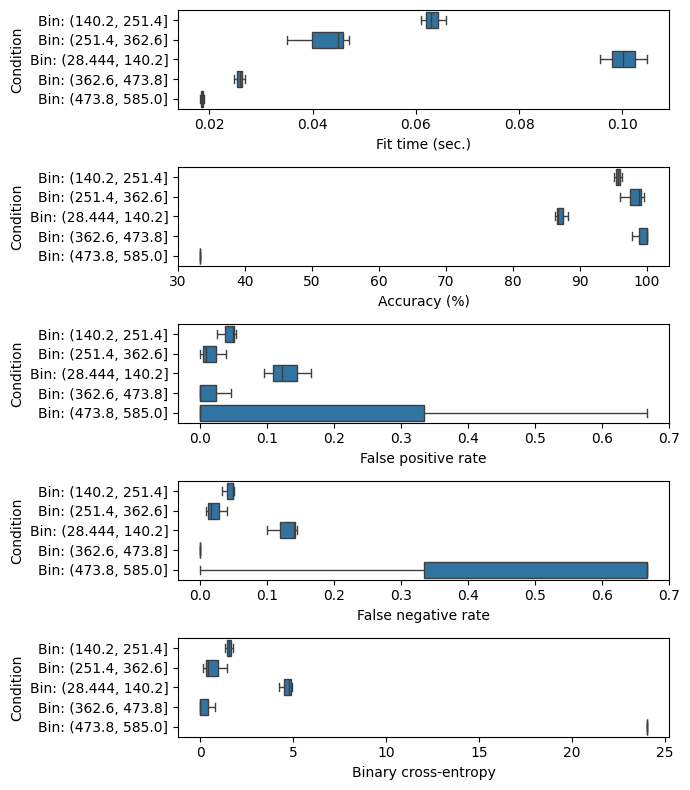

In [12]:
# Loop on the bins
for bin_string in bin_strings:
    print(f'Bin: {bin_string}')

    # Grab the data for this bin
    bin_training_data = training_data_df[training_data_df['Length bin (tokens)'] == bin_string]

    # Split the data into features and labels
    labels_train = bin_training_data['Source']
    features_train_df = bin_training_data.drop('Source', axis = 1)

    # Encode string class values as integers
    label_encoder = LabelEncoder()
    label_encoder = label_encoder.fit(labels_train)
    labels_train = label_encoder.transform(labels_train)

    # Drop the bin string and make a numpy copy
    features_train_df = features_train_df.drop('Length bin (tokens)', axis = 1)
    features_train = features_train_df.to_numpy()

    print(f'Training data: {len(labels_train)} examples')

    # Instantiate an XGBoost model
    model = XGBClassifier()

    # Run cross-validation
    scores = cross_validate(
        model,
        features_train,
        labels_train,
        cv = cv_folds,
        n_jobs = -1,
        scoring = scoring
    )

    # Collect and plot the results
    results = helper_funcs.add_cv_scores(results, scores, f'Bin: {bin_string}')

plot_funcs.plot_cross_validation(plots, results).show()

So, I think this might have potential - it's the short fragments that are killing our accuracy. What I don't know is if we were to build a compound classifier out of models trained on each bin, would it do any better overall than one classifier trained with length as a feature. Seems like it could - the short bin gives 88% accuracy, which is about what we get with a single classifier. The other long bins score in the mid/high 90s and contain more data together than the short bin.